In [1]:
import os
import glob 
import pandas as pd
import numpy as np



pattern = os.path.join('..', 'data', 'prepared', '*.csv')
files = glob.glob(pattern)
df = pd.read_csv(files[1], sep=';')
df2 = pd.read_csv(files[0], sep=';')

def safe_int_conversion(x):
    try:
        return int(x)
    except (ValueError, TypeError):
        return None

def compute_code_insee(row):
    code_dept = safe_int_conversion(row['Code departement'])
    code_commune = safe_int_conversion(row['Code commune'])
    if code_dept is not None and code_commune is not None:
        return str((code_dept * 1000) + code_commune).zfill(5)
    return '00000'

df['Code insee'] = df.apply(compute_code_insee, axis=1)

df_data = pd.DataFrame()
cols_to_keep = [
    'Valeur fonciere',
    'Surface reelle bati', 
    'Nombre pieces principales', 
    'Surface terrain', 
    'Code insee'
]
df_data = df[cols_to_keep]

df2_data = pd.DataFrame()
col_to_keep = [
    'code_insee',
    'population',
    'superficie_km2',
    'densite',
    'altitude_moyenne',
    'latitude_centre',
    'longitude_centre',
    'niveau_equipements_services'
]
df2_data = df2[col_to_keep]

df_merged = pd.merge(df_data, df2_data, left_on='Code insee', right_on='code_insee')
df_merged.drop(columns=['code_insee'], inplace=True)



def traiter_outliers(df, cols=None, iqr_multiplier=1.5, drop=True, verbose=True):
    """
    Détecte et retire les outliers par colonne en utilisant la méthode IQR.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame d'entrée.
    cols : list or None
        Liste de colonnes à traiter. Si None, on prend les colonnes numériques.
    iqr_multiplier : float
        Multiplicateur IQR (1.5 par défaut).
    drop : bool
        Si True, retourne un nouveau DataFrame sans les lignes outliers. Si False, retourne le masque booléen des outliers.
    verbose : bool
        Affiche un résumé par colonne.

    Returns
    -------
    pd.DataFrame or pd.Series
        DataFrame nettoyé si drop=True sinon Series bool (True = outlier).
    """

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(cols) == 0:
        if verbose:
            print("Aucune colonne numérique trouvée pour détecter les outliers.")
        return df.copy() if drop else pd.Series(False, index=df.index)

    # masque global qui sera True pour les lignes considérées outliers sur au moins une colonne
    outlier_mask = pd.Series(False, index=df.index)

    for col in cols:
        # calculs robustes en ignorant les NaN
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR

        mask = (df[col] < lower) | (df[col] > upper)
        outlier_mask = outlier_mask | mask

        if verbose:
            n_out = int(mask.sum())
            pct = 100 * n_out / len(df)
            print(f"Colonne '{col}': outliers = {n_out} / {len(df)} ({pct:.2f}%) | bounds=({lower:.2f}, {upper:.2f})")

    if drop:
        df_clean = df.loc[~outlier_mask].reset_index(drop=True)
        if verbose:
            print(f"\nTotal lignes supprimées : {int(outlier_mask.sum())} / {len(df)} ({100*outlier_mask.sum()/len(df):.2f}%)")
        return df_clean
    else:
        return outlier_mask

# Exemple d'utilisation :
# df_merged_clean = traiter_outliers(df_merged)
# ou pour obtenir le masque : mask = traiter_outliers(df_merged, drop=False)

df_merged_clean = traiter_outliers(df_merged)


Colonne 'Valeur fonciere': outliers = 17999 / 285216 (6.31%) | bounds=(-148755.62, 541259.38)
Colonne 'Surface reelle bati': outliers = 11762 / 285216 (4.12%) | bounds=(-23.50, 172.50)
Colonne 'Nombre pieces principales': outliers = 2189 / 285216 (0.77%) | bounds=(-1.00, 7.00)
Colonne 'Surface terrain': outliers = 14631 / 285216 (5.13%) | bounds=(-600.00, 1000.00)
Colonne 'population': outliers = 36606 / 285216 (12.83%) | bounds=(-74342.00, 132770.00)
Colonne 'superficie_km2': outliers = 29766 / 285216 (10.44%) | bounds=(-45.50, 102.50)
Colonne 'densite': outliers = 20953 / 285216 (7.35%) | bounds=(-3376.00, 6008.00)
Colonne 'altitude_moyenne': outliers = 23825 / 285216 (8.35%) | bounds=(-210.00, 446.00)
Colonne 'latitude_centre': outliers = 0 / 285216 (0.00%) | bounds=(37.64, 55.55)
Colonne 'longitude_centre': outliers = 0 / 285216 (0.00%) | bounds=(-5.36, 10.92)
Colonne 'niveau_equipements_services': outliers = 0 / 285216 (0.00%) | bounds=(-1.00, 7.00)

Total lignes supprimées : 1154

In [ ]:
# Recherche des meilleurs modèles
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Creation des jeux d'entrainement et de validation
y = df_merged_clean['Valeur fonciere']
X = df_merged_clean.drop(columns=['Valeur fonciere', 'Code insee', ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionnaire des modèles à tester
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost' : XGBRegressor(),
    'SVR' : SVR()
}

# Tester chaque modèle
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    results[name] = scores.mean()
    print(f"{name:20s} : R2 = {scores.mean():.4f} (+/- {scores.std():.4f})")

# Meilleur modèle
best_model = max(results, key=results.get)
print(f"\n🏆 Meilleur modèle : {best_model}")

Random Forest        : R2 = 0.6250 (+/- 0.0068)
Gradient Boosting    : R2 = 0.5253 (+/- 0.0067)
Gradient Boosting    : R2 = 0.5253 (+/- 0.0067)
XGBoost              : R2 = 0.6470 (+/- 0.0068)
XGBoost              : R2 = 0.6470 (+/- 0.0068)


In [4]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

#Definition du répertoire de sauvegarde des modèles
model_dir = os.path.join(os.getcwd(), "..", "models")
os.makedirs(model_dir, exist_ok=True)

# Creation des jeux d'entrainement et de validation
y = df_merged_clean['Valeur fonciere']
X = df_merged_clean.drop(columns=['Valeur fonciere', 'Code insee', ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration de MLflow   
#mlflow.set_tracking_uri("file://" + os.path.join(os.getcwd(), "mlruns"))
#mlflow.set_experiment("mon_experience_immobilier_2")

# Dictionnaire des modèles à tester
models = {
    #'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost' : XGBRegressor()  
}

# Grille de paramètres à tester
param_grid = {
    'model__n_estimators': [50, 100, 200],          # Nombre d'arbres
    'model__learning_rate': [0.01, 0.1, 0.2],       # Taux d'apprentissage
    'model__max_depth': [3, 5, 7]                   # Profondeur des arbres
}

# Tester chaque modèle
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)

    # Afficher les résultats
    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    print(f"Meilleur score R2 : {grid_search.best_score_:.4f}")

    
    # Tester sur les données de validation
    best_model = grid_search.best_estimator_
    preds = best_model.predict(X_valid)
    r2_valid = r2_score(y_valid, preds)
    print(f"R2 sur validation : {r2_valid:.4f}")



Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Meilleur score R2 : 0.6560
R2 sur validation : 0.6564
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Meilleur score R2 : 0.6585
R2 sur validation : 0.6596


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Optionnel, à tester sans aussi

# Creation des jeux d'entrainement et de validation
y = df_merged_clean['Valeur fonciere']
X = df_merged_clean.drop(columns=['Valeur fonciere', 'Code insee', ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# Définir le pipeline (avec ou sans scaling)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Décommente si tu veux tester avec scaling
    ('model', RandomForestRegressor(random_state=42))
])

# Grille d'hyperparamètres à tester
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Nombre d'arbres
    'model__max_depth': [10, 20, 30],  # Profondeur maximale des arbres
    'model__min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons pour split
    'model__min_samples_leaf': [1, 2, 4]  # Nombre minimal d'échantillons par feuille
    #'model__max_features': 'sqrt' # Nombre de features à considérer pour chaque split
    #'model__bootstrap': [True, False]        # Avec ou sans bootstrap
}

# Définir la validation croisée (5 folds par défaut)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Créer le GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',  # Métrique R²
    n_jobs=-1,     # Utilise tous les cœurs disponibles
    verbose=2      # Affiche les détails pendant la recherche
)

# Lancer la recherche
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et score
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score R² :", grid_search.best_score_)

# Prédire avec le meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
r2_valid = r2_score(y_valid, preds)
print(f"R2 sur validation : {r2_valid:.4f}")


R2 = 0.6566


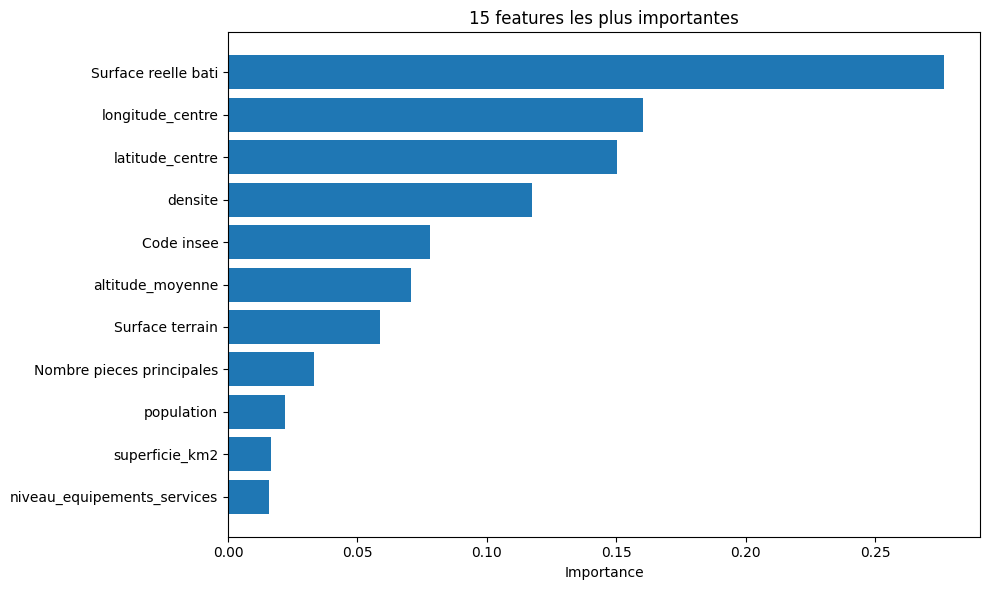

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y = df_merged_clean['Valeur fonciere']
X = df_merged_clean.drop(columns=['Valeur fonciere'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(
        random_state=42,
        n_estimators=200,
        learning_rate=0.2,
        max_depth=7
    ))
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

r2 = r2_score(y_valid, preds)
print(f"R2 = {r2:.4f}")

# Visualisation de l'importance des features
# Récupérer les importances des features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('15 features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()